In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import lightgbm
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

import optuna
from optuna.trial import Trial
import optuna.integration.lightgbm as lgb


from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.ensemble import RandomForestClassifier
import sklearn.datasets
from sklearn.model_selection import train_test_split

from functools import partial

In [2]:
raw_data = pd.read_pickle(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Assignment/dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

# Problem 1

## Random Forest

In [6]:
shap_features_rf = pd.read_pickle(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Lecture_8/Random Forest Parameters/shap_features.pkl')

In [7]:
from collections import Counter

In [8]:
shap_features_list_rf = [item for sublist in shap_features_rf for item in sublist]
shap_features_rf_items = Counter(shap_features_list_rf)
shap_features_rf = [x[0] for x in Counter(shap_features_list_rf).most_common(10)]
shap_features_rf

['fcf_yield',
 'cf_yield',
 'oancfy',
 'oancfy_q',
 'fcf_csfhdq',
 'lt_ppentq',
 'evmq',
 'dprq',
 'oepsxy',
 'dvpspq']

In [9]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [10]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [11]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [12]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [13]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [14]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [15]:
with open(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Lecture_8/Random Forest Parameters/optimal_hyperparameters.pkl','rb') as f:
    optimal_hyperparameters_rf = pickle.load(f)

In [16]:
classifiers_rf = []
for hyp_par in optimal_hyperparameters_rf:
    rf_clf = RandomForestClassifier(**hyp_par)
    classifiers_rf.append(rf_clf)

In [17]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [18]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [19]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [20]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_rf]),columns=shap_features_rf) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_rf]),columns=shap_features_rf) for i in range(len(start_dates)-1)]

In [21]:
opt_test_data[1]

,fcf_yield,cf_yield,oancfy,oancfy_q,fcf_csfhdq,lt_ppentq,evmq,dprq,oepsxy,dvpspq
0,-0.206398,-0.645950,-0.171431,-0.142220,-0.222443,-0.138036,0.080339,-0.042204,-0.093053,-0.595682
1,-0.420684,2.792597,0.852188,0.210787,-0.359797,-0.137840,-1.060025,-0.112661,-0.578317,-0.408904
2,-0.020692,-0.102749,-0.051488,-0.110094,-0.118421,-0.143237,0.013442,-0.006715,0.215752,-0.198778
3,0.049269,-0.199209,-0.200669,-0.110826,0.041014,-0.126797,0.011170,-0.030968,0.107470,-0.595682
4,0.006049,-0.332625,1.494588,1.340345,0.089421,-0.136787,0.018215,0.007137,0.307992,0.478292
...,...,...,...,...,...,...,...,...,...,...
1131,-0.062845,-0.275955,-0.011859,0.030989,-0.150327,-0.125497,-0.007114,0.091678,-0.133157,0.618376
1132,-0.036429,-0.386222,-0.195607,-0.156680,0.068950,-0.122519,0.014597,-0.023044,0.099449,-0.408904
1133,-0.242139,0.414694,-0.090863,0.021878,-0.311895,-0.146362,0.002207,-0.042204,-0.297586,-0.595682
1134,-0.032373,-0.453909,-0.213380,-0.163768,0.006329,-0.099544,0.015523,-0.042204,0.051323,-0.595682


In [24]:
x_rf = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers_rf[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers_rf[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x_rf.append(x_rf[i] + (x_rf[i]/num_names)*profit_i)

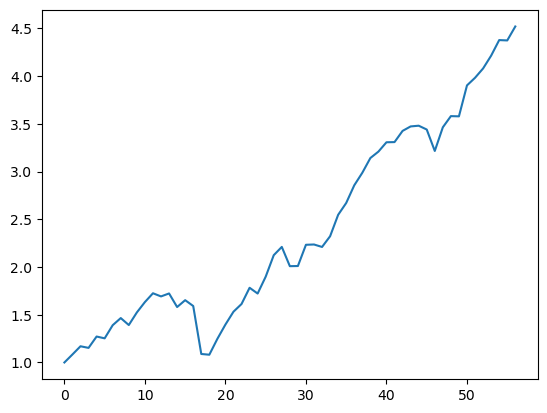

In [25]:
plt.plot(x_rf);

## Gradient Boosting

In [26]:
shap_features_gb = pd.read_pickle('/Users/qigege/Desktop/33160 Machine Learning in Finance/Lecture_8/Gradient Boosting Parameters/shap_features_gb_clf_01.pkl')

In [27]:
shap_features_list_gb = [item for sublist in shap_features_gb for item in sublist]
shap_features_gb_items = Counter(shap_features_list_gb)
shap_features_gb = [x[0] for x in Counter(shap_features_list_gb).most_common(10)]
shap_features_gb

['cf_yield',
 'fcf_yield',
 'evmq',
 'dvpspq',
 'rect_turnq',
 'lt_ppentq',
 'debt_assetsq',
 'oepsxy',
 'dprq',
 'fcf_ocfq']

In [29]:
with open(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Lecture_8/Gradient Boosting Parameters/classifiers_gb_clf_01.pkl','rb') as f:
    classifiers_gb = pickle.load(f)

In [30]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_gb]),columns=shap_features_gb) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_gb]),columns=shap_features_gb) for i in range(len(start_dates)-1)]

In [31]:
opt_test_data[1]

,cf_yield,fcf_yield,evmq,dvpspq,rect_turnq,lt_ppentq,debt_assetsq,oepsxy,dprq,fcf_ocfq
0,-0.645950,-0.206398,0.080339,-0.595682,-0.020232,-0.138036,-1.490220,-0.093053,-0.042204,0.016412
1,2.792597,-0.420684,-1.060025,-0.408904,-0.037180,-0.137840,1.037241,-0.578317,-0.112661,-0.142052
2,-0.102749,-0.020692,0.013442,-0.198778,28.472902,-0.143237,-0.687620,0.215752,-0.006715,-0.032309
3,-0.199209,0.049269,0.011170,-0.595682,-0.030696,-0.126797,0.170006,0.107470,-0.030968,0.019577
4,-0.332625,0.006049,0.018215,0.478292,-0.024281,-0.136787,-0.065720,0.307992,0.007137,0.041016
...,...,...,...,...,...,...,...,...,...,...
1131,-0.275955,-0.062845,-0.007114,0.618376,-0.025998,-0.125497,0.454082,-0.133157,0.091678,-0.019563
1132,-0.386222,-0.036429,0.014597,-0.408904,-0.031240,-0.122519,-0.450633,0.099449,-0.023044,0.035326
1133,0.414694,-0.242139,0.002207,-0.595682,-0.029572,-0.146362,-0.970810,-0.297586,-0.042204,-0.126750
1134,-0.453909,-0.032373,0.015523,-0.595682,-0.025630,-0.099544,-1.279463,0.051323,-0.042204,0.079060


In [32]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [33]:
x_gb = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers_gb[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers_gb[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x_gb.append(x_gb[i] + (x_gb[i]/num_names)*profit_i)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160

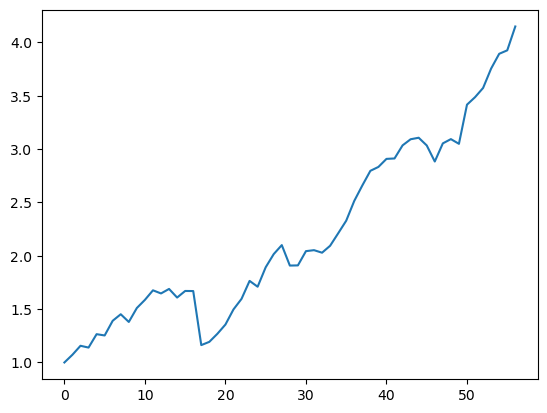

In [34]:
plt.plot(x_gb);

## Compare with SPY and Sharp Ratios

In [35]:
SPY = pd.read_pickle(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Assignment/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy_random_forest'] = x_rf
SPY['strategy_gradient_boosting'] = x_gb

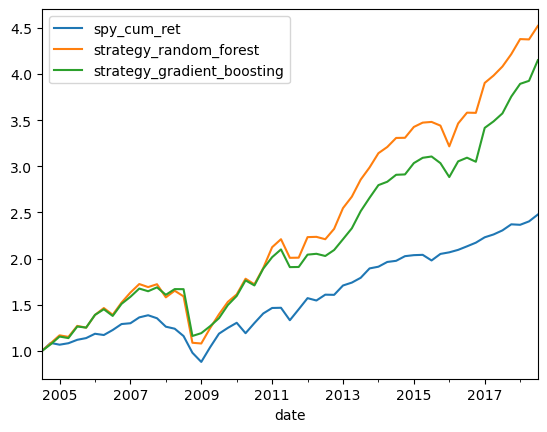

In [36]:
SPY.plot();

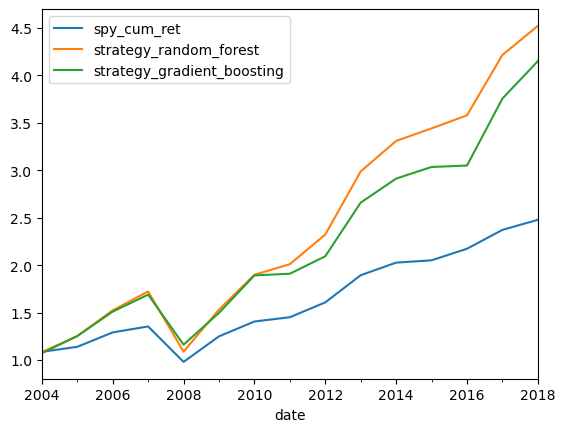

In [37]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [38]:
def SharpeRatio(ret):
    strategy_mean_ret = (ret - 1).diff().mean()
    strategy_std = (ret - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    return strategy_sr

In [39]:
SharpeRatio(SPY)

spy_cum_ret                   0.632465
strategy_random_forest        0.800977
strategy_gradient_boosting    0.760341
dtype: float64

# Question 2

In [40]:
rf = SPY['strategy_random_forest']
gb = SPY['strategy_gradient_boosting']
spy = SPY['spy_cum_ret']

In [41]:
import random

In [42]:
def findbestweight(loop_num,weight_lower_bound,weight_upper_bound):
    sr_max = 0
    optimal_w_rf,optimal_w_gb,optimal_w_spy=1,0,0
    for i in range(loop_num):
        w_rf=random.uniform(weight_lower_bound,weight_upper_bound) 
        w_gb=random.uniform(weight_lower_bound,weight_upper_bound) 
        w_spy=1-w_rf-w_gb
        hedge_ret = w_rf*rf + w_gb*gb + w_spy*spy
        sr_temp = SharpeRatio(hedge_ret)
        if sr_temp > sr_max:
            sr_max = sr_temp
            optimal_w_rf = w_rf
            optimal_w_gb = w_gb
            optimal_w_spy = w_spy
    return {'sr_max':sr_max,'w_rf':optimal_w_rf,'w_gb':optimal_w_gb,'w_spy':optimal_w_spy}

In [43]:
findbestweight(1000,-2,2)

{'sr_max': 0.843175980440602,
 'w_rf': 1.9428387893815717,
 'w_gb': 0.1341247635833196,
 'w_spy': -1.0769635529648913}

Thus, we choose the weight of random forest be 1.94, the weight of gradient boosting be 0.13, and the weight of SPY be -1.07.

In [44]:
SPY['hedge']=1.94*rf + 0.13*gb - 1.07*spy

<AxesSubplot:xlabel='date'>

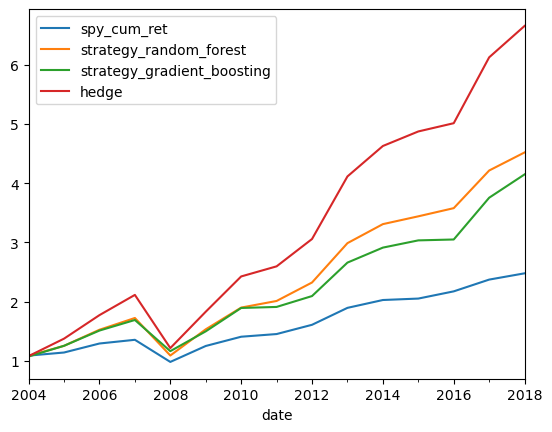

In [45]:
SPY.plot()

In [46]:
SharpeRatio(SPY)

spy_cum_ret                   0.632465
strategy_random_forest        0.800977
strategy_gradient_boosting    0.760341
hedge                         0.843084
dtype: float64